In [1]:
import numpy as np
import time
import pickle as pk
from numba import cuda
import json
import math

# Gerênciando propriedades constantes

In [2]:
Db = 0.0001
Dn = 0.0001
phi = 0.2
cb = 0.15
lambd_nb = 1.8
mi_n = 0.2
lambd_bn = 0.1
y_n = 0.1
Cn_max = 0.5
X_nb = 1e-4
central_ini_cond = 0.5
ini_cond_var = 0.2

# Serializing json
constant_properties = json.dumps(
    {
        "Db": Db,
        "Dn": Dn,
        "phi": phi,
        "cb": cb,
        "lambd_nb": lambd_nb,
        "mi_n": mi_n,
        "lambd_bn": lambd_bn,
        "y_n": y_n,
        "Cn_max": Cn_max,
        "X_nb": X_nb,
        "central_ini_cond": central_ini_cond,
        "ini_cond_var": ini_cond_var,
    },
    indent=4,
)

# Writing to sample.json
with open("control_dicts/constant_properties.json", "w") as outfile:
    outfile.write(constant_properties)

# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]
ini_cond_var = constant_properties["ini_cond_var"]

# Gerenciando propriedades de malha

In [3]:
h = 0.05
k = 0.0056
x_dom = (0, 1)
y_dom = (0, 1)
t_dom = (0, 10)

# Serializing json
mesh_properties = json.dumps(
    {
        "h": h,
        "k": k,
        "x_dom": x_dom,
        "y_dom": y_dom,
        "t_dom": t_dom,
    },
    indent=4,
)

# Writing to sample.json
with open("control_dicts/mesh_properties.json", "w") as outfile:
    outfile.write(mesh_properties)

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]

# Inicializando variáveis

In [4]:
def make_init_cond(x_dom, y_dom, t_dom, h, k, central_ini_cond, ini_cond_var):
    size_x = int(((x_dom[1] - x_dom[0]) / (h)))
    size_y = int(((y_dom[1] - y_dom[0]) / (h)))
    size_t = int(((t_dom[1] - t_dom[0]) / (k)) + 1)

    initial_cond = np.linspace(
        central_ini_cond * (1 - ini_cond_var),
        central_ini_cond * (1 + ini_cond_var),
        num=size_t,
        endpoint=True,
    )

    print("Size x = {:d}, y = {:d} \n ".format(size_x, size_y))

    print(
        "Steps in time = {:d}\nSteps in space_x = {:d}\nSteps in space_y = {:d}\n".format(
            size_t,
            size_x,
            size_y,
        )
    )

    return size_x, size_y, size_t, initial_cond


size_x, size_y, size_t, initial_cond = make_init_cond(
    x_dom, y_dom, t_dom, h, k, central_ini_cond, ini_cond_var
)

Size x = 20, y = 20 
 
Steps in time = 1786
Steps in space_x = 20
Steps in space_y = 20



In [5]:
struct_name = (
    "h--"
    + str(h)
    + "__k--"
    + str(k)
    + "__x_dom_min--"
    + str(x_dom[0])
    + "__x_dom_max--"
    + str(x_dom[-1])
    + "__y_dom_min--"
    + str(y_dom[0])
    + "__y_dom_max--"
    + str(y_dom[-1])
    + "__t_dom_min--"
    + str(t_dom[0])
    + "__t_dom_max--"
    + str(t_dom[-1])
)

print("struct_name: ", struct_name)

struct_name:  h--0.05__k--0.0056__x_dom_min--0__x_dom_max--1__y_dom_min--0__y_dom_max--1__t_dom_min--0__t_dom_max--10


# Versão Serial

In [6]:
# Função que descreve a taxa de variação da concentração de bactérias (Cb)
def fb(Cb, Cn, i, j):
    # O crescimento de bactérias é reduzido pela presença de neutrófilos (Cn)
    # por um fator lambd_nb
    return (cb - lambd_nb * Cn[i, j]) * Cb[i, j]


# Função que descreve a taxa de variação da concentração de neutrófilos (Cn)
def fn(Cb, Cn, i, j):
    # Crescimento dos neutrófilos depende da presença de bactérias (Cb)
    # Também considera uma taxa de decaimento natural (mi_n) e a interação com
    # bactérias (lambd_bn)
    return (
        y_n * Cb[i, j] * (Cn_max - Cn[i, j])
        - lambd_bn * Cn[i, j] * Cb[i, j]
        - mi_n * Cn[i, j]
    )


def fx_Cb_right(Cb, i, j):
    return 0 if i == size_x - 1 else (Cb[i + 1, j] - Cb[i, j])


def fx_Cb_left(Cb, i, j):
    return 0 if i == 0 else (Cb[i, j] - Cb[i - 1, j])


def fx_Cb_up(Cb, i, j):
    return 0 if i == size_y - 1 else (Cb[i, j + 1] - Cb[i, j])


def fx_Cb_down(Cb, i, j):
    return 0 if i == 0 else (Cb[i, j] - Cb[i, j - 1])


# Função para aplicar condições iniciais à concentração de bactérias (Cb)
def apply_initial_conditions(Cb, tam_max):
    # Para uma região central do domínio, define uma concentração inicial de bactérias
    for i in range(tam_max):
        for j in range(tam_max):
            if (i * h >= 0.4) and (i * h) <= 0.6:
                if (j * h >= 0.4) and (j * h) <= 0.6:
                    Cb[i][j] = 0.2

    return Cb


# Função principal para resolver as equações diferenciais parciais usando diferenças finitas
def solve_pde(verbose=False):
    # Definindo o tamanho das malhas (discretização espacial e temporal)
    size_x = int(((x_dom[1] - x_dom[0]) / (h)))
    size_y = int(((y_dom[1] - y_dom[0]) / (h)))
    size_t = int(((t_dom[1] - t_dom[0]) / (k)) + 1)

    # Inicializando as matrizes para concentrações de neutrófilos (Cn) e bactérias (Cb)
    Cn_new = np.zeros((size_x, size_y))
    Cb_new = np.zeros((size_x, size_y))

    # Matrizes para armazenar as concentrações em cada passo de tempo
    Cn_final = np.zeros((size_t, size_x, size_y))
    Cb_final = np.zeros((size_t, size_x, size_y))

    # Aplicando condições iniciais para a concentração de bactérias
    Cb_new = apply_initial_conditions(Cb_new, size_x)

    # Armazenando as condições iniciais
    Cb_final[0] = Cb_new
    Cn_final[0] = Cn_new

    # Loop sobre o tempo
    for time in range(1, size_t):
        # Atualizando as concentrações anteriores (passo temporal anterior)
        Cn_old = Cn_new.copy()
        Cb_old = Cb_new.copy()

        global_max_v = 0

        # Loop sobre o espaço (malha espacial)
        for i in range(size_x):

            for j in range(size_y):

                fx_Cb_right = (
                    0 if (i == size_x - 1) else (Cb_old[i + 1, j] - Cb_old[i, j])
                )

                fx_Cb_left = 0 if (i == 0) else (Cb_old[i, j] - Cb_old[i - 1, j])

                fx_Cb_up = 0 if (j == size_y - 1) else (Cb_old[i, j + 1] - Cb_old[i, j])

                fx_Cb_down = 0 if (j == 0) else (Cb_old[i, j] - Cb_old[i, j - 1])

                max_vx = np.max((fx_Cb_left, fx_Cb_right))

                max_vy = np.max((fx_Cb_down, fx_Cb_up))

                max_v = max_vx + max_vy

                if max_v > global_max_v:
                    global_max_v = max_v

                # Atualizando as concentrações de bactérias
                Cb_new[i][j] = (
                    (k * Db)
                    / (h * h * phi)
                    * (fx_Cb_right * fx_Cb_right - fx_Cb_left + fx_Cb_up - fx_Cb_down)
                    + (k / phi) * fb(Cb_old, Cn_old, i, j)
                    + Cb_old[i, j]
                )

                fx_Cn_right = (
                    0 if i == size_x - 1 else ((Cn_old[i + 1, j] - Cn_old[i, j]))
                )

                fx_Cn_left = 0 if i == 0 else ((Cn_old[i, j] - Cn_old[i - 1, j]))

                fx_Cn_up = 0 if j == size_y - 1 else ((Cn_old[i, j + 1] - Cn_old[i, j]))

                fx_Cn_down = 0 if j == 0 else ((Cn_old[i, j] - Cn_old[i, j - 1]))

                adv_right = (
                    0
                    if i == size_x - 1
                    else (
                        (Cn_old[i, j] * fx_Cb_right)
                        if fx_Cb_right > 0
                        else (Cn_old[i + 1, j] * fx_Cb_right)
                    )
                )

                adv_left = (
                    0
                    if i == 0
                    else (
                        (Cn_old[i, j] * fx_Cb_left)
                        if fx_Cb_left > 0
                        else (Cn_old[i - 1, j] * fx_Cb_left)
                    )
                )

                adv_up = (
                    0
                    if j == size_y - 1
                    else (
                        (Cn_old[i, j] * fx_Cb_up)
                        if fx_Cb_up > 0
                        else (Cn_old[i, j + 1] * fx_Cb_up)
                    )
                )

                adv_down = (
                    0
                    if j == 0
                    else (
                        (Cn_old[i, j] * fx_Cb_down)
                        if fx_Cb_down > 0
                        else (Cn_old[i, j - 1] * fx_Cb_down)
                    )
                )

                # Atualizando as concentrações de neutrófilos
                Cn_new[i][j] = (
                    (k * Dn)
                    / (h * h * phi)
                    * (fx_Cn_right - fx_Cn_left + fx_Cn_up - fx_Cn_down)
                    - (X_nb * k)
                    / (h * h * phi)
                    * (adv_right - adv_left + adv_up - adv_down)
                    + (k / phi) * fn(Cb_old, Cn_old, i, j)
                    + Cn_old[i, j]
                )

                # Armazenando os resultados para o passo de tempo atual
                Cb_final[time][i][j] = Cb_new[i][j]
                Cn_final[time][i][j] = Cn_new[i][j]

        # Calcula critério de CFL

        cfl = (global_max_v * k) / (h * h)

        if cfl > 1:
            print(
                "ERROR - CFL criterium not matched on iteration {}: {}".format(
                    time, cfl
                )
            )
            break
        else:
            if (time % 100 == 0 or time == 0) and verbose:
                print("CFL criterium on iteration {}: {}".format(time, cfl))

    # Retornando as matrizes finais de concentração de bactérias e neutrófilos ao
    # longo do tempo
    return Cb_final, Cn_final

In [7]:
start = time.time()

Cb, Cn = solve_pde()

end = time.time()

serial_time = end - start

with open("fdm_sim/Cp__" + struct_name + ".pkl", "wb") as f:
    pk.dump(Cb, f)

with open("fdm_sim/Cl__" + struct_name + ".pkl", "wb") as f:
    pk.dump(Cn, f)

# Versão paralela

In [8]:
# Função que descreve a taxa de variação da concentração de bactérias (Cb)
@cuda.jit(device=True)
def cu_fb(Cb, Cn, i, j, cb, lambd_nb):
    # O crescimento de bactérias é reduzido pela presença de neutrófilos (Cn)
    # por um fator lambd_nb
    return (cb - lambd_nb * Cn[i, j]) * Cb[i, j]


# Função que descreve a taxa de variação da concentração de neutrófilos (Cn)
@cuda.jit(device=True)
def cu_fn(Cb, Cn, i, j, y_n, Cn_max, lambd_bn, mi_n):
    # Crescimento dos neutrófilos depende da presença de bactérias (Cb)
    # Também considera uma taxa de decaimento natural (mi_n) e a interação com
    # bactérias (lambd_bn)
    return (
        y_n * Cb[i, j] * (Cn_max - Cn[i, j])
        - lambd_bn * Cn[i, j] * Cb[i, j]
        - mi_n * Cn[i, j]
    )


# Função para aplicar condições iniciais à concentração de bactérias (Cb)
@cuda.jit(device=True)
def cu_apply_initial_conditions(Cb, tam_max):
    # Para uma região central do domínio, define uma concentração inicial de bactérias
    for i in range(tam_max):
        for j in range(tam_max):
            if (i * h >= 0.4) and (i * h) <= 0.6:
                if (j * h >= 0.4) and (j * h) <= 0.6:
                    Cb[i][j] = 0.2

    return Cb


# Função principal para resolver as equações diferenciais parciais usando diferenças finitas
@cuda.jit()
def cu_solve_pde(
    Cb_buf_0,
    Cn_buf_0,
    Cb_buf_1,
    Cn_buf_1,
    Cb_final,
    Cn_final,
    size_t,
    size_x,
    size_y,
    h,
    k,
    Db,
    Dn,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    Cn_max,
    X_nb,
):

    # Thread id in a 2D block
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    # Block id in a 2D grid
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y

    # Block width, i.e. number of threads per block
    bwx = cuda.blockDim.x
    bwy = cuda.blockDim.y

    # Domain position
    i, j = cuda.grid(2)

    # print(
    #     "\nThread ids in a 2D block",
    #     tx,
    #     ty,
    #     "\nBlock ids in a 2D grid",
    #     bx,
    #     by,
    #     "\nBlock width, i.e. number of threads per block",
    #     bwx,
    #     bwy,
    #     "\nDomain position ",
    #     i,
    #     j,
    # )

    # Aplicando condições iniciais para a concentração de bactérias
    Cb_buf_0 = cu_apply_initial_conditions(Cb_buf_0, size_x)

    # Armazenando as condições iniciais
    Cb_final[0][i, j] = Cb_buf_0[i, j]
    Cn_final[0][i, j] = Cn_buf_0[i, j]

    # Don't continue if our index is outside the domain

    if i >= size_x or j >= size_y:
        return

    # Prepare to do a grid-wide synchronization later

    grid = cuda.cg.this_grid()

    # Loop sobre o tempo
    for time in range(1, size_t):
        # Atualizando as concentrações anteriores (passo temporal anterior)

        if (time % 2) == 0:

            Cn_old = Cn_buf_1
            Cb_old = Cb_buf_1

            Cn_new = Cn_buf_0
            Cb_new = Cb_buf_0

        else:
            Cn_old = Cn_buf_0
            Cb_old = Cb_buf_0

            Cn_new = Cn_buf_1
            Cb_new = Cb_buf_1

        fx_Cb_right = 0 if (i == size_x - 1) else (Cb_old[i + 1, j] - Cb_old[i, j])

        fx_Cb_left = 0 if (i == 0) else (Cb_old[i, j] - Cb_old[i - 1, j])

        fx_Cb_up = 0 if (j == size_y - 1) else (Cb_old[i, j + 1] - Cb_old[i, j])

        fx_Cb_down = 0 if (j == 0) else (Cb_old[i, j] - Cb_old[i, j - 1])

        # Atualizando as concentrações de bactérias
        Cb_new[i][j] = (
            (k * Db)
            / (h * h * phi)
            * (fx_Cb_right * fx_Cb_right - fx_Cb_left + fx_Cb_up - fx_Cb_down)
            + (k / phi) * cu_fb(Cb_old, Cn_old, i, j, cb, lambd_nb)
            + Cb_old[i, j]
        )

        fx_Cn_right = 0 if i == size_x - 1 else ((Cn_old[i + 1, j] - Cn_old[i, j]))

        fx_Cn_left = 0 if i == 0 else ((Cn_old[i, j] - Cn_old[i - 1, j]))

        fx_Cn_up = 0 if j == size_y - 1 else ((Cn_old[i, j + 1] - Cn_old[i, j]))

        fx_Cn_down = 0 if j == 0 else ((Cn_old[i, j] - Cn_old[i, j - 1]))

        adv_right = (
            0
            if i == size_x - 1
            else (
                (Cn_old[i, j] * fx_Cb_right)
                if fx_Cb_right > 0
                else (Cn_old[i + 1, j] * fx_Cb_right)
            )
        )

        adv_left = (
            0
            if i == 0
            else (
                (Cn_old[i, j] * fx_Cb_left)
                if fx_Cb_left > 0
                else (Cn_old[i - 1, j] * fx_Cb_left)
            )
        )

        adv_up = (
            0
            if j == size_y - 1
            else (
                (Cn_old[i, j] * fx_Cb_up)
                if fx_Cb_up > 0
                else (Cn_old[i, j + 1] * fx_Cb_up)
            )
        )

        adv_down = (
            0
            if j == 0
            else (
                (Cn_old[i, j] * fx_Cb_down)
                if fx_Cb_down > 0
                else (Cn_old[i, j - 1] * fx_Cb_down)
            )
        )

        # Atualizando as concentrações de neutrófilos
        Cn_new[i][j] = (
            (k * Dn)
            / (h * h * phi)
            * (fx_Cn_right - fx_Cn_left + fx_Cn_up - fx_Cn_down)
            - (X_nb * k) / (h * h * phi) * (adv_right - adv_left + adv_up - adv_down)
            + (k / phi) * cu_fn(Cb_old, Cn_old, i, j, y_n, Cn_max, lambd_bn, mi_n)
            + Cn_old[i, j]
        )

        # Armazenando os resultados para o passo de tempo atual
        Cb_final[time][i][j] = Cb_new[i][j]
        Cn_final[time][i][j] = Cn_new[i][j]

        grid.sync()

# Comparação entre versões

In [9]:
from fvm_model_parallel import cu_solve_pde

start = time.time()

# Definindo número de threads e blocos para cuda

threadsperblock = (size_x, size_y)
blockspergrid_x = math.ceil(size_x / threadsperblock[0])
blockspergrid_y = math.ceil(size_y / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

# Inicializando as matrizes para concentrações de neutrófilos (Cn) e bactérias (Cb)

Cb_buf_0 = cuda.to_device(np.zeros((size_x, size_y)))
Cn_buf_0 = cuda.to_device(np.zeros((size_x, size_y)))

# This extra array is used for synchronization purposes

Cb_buf_1 = cuda.device_array_like(Cb_buf_0)
Cn_buf_1 = cuda.device_array_like(Cn_buf_0)

# Matrizes para armazenar as concentrações em cada passo de tempo
Cb_final_device = cuda.to_device(np.zeros((size_t, size_x, size_y)))
Cn_final_device = cuda.to_device(np.zeros((size_t, size_x, size_y)))

cu_solve_pde[threadsperblock, blockspergrid](
    Cb_buf_0,
    Cn_buf_0,
    Cb_buf_1,
    Cn_buf_1,
    Cb_final_device,
    Cn_final_device,
    size_t,
    size_x,
    size_y,
    h,
    k,
    Db,
    Dn,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    Cn_max,
    X_nb,
)

Cb_host = np.empty(shape=Cb_final_device.shape, dtype=Cb_final_device.dtype)
Cb_final_device.copy_to_host(Cb_host)

Cn_host = np.empty(shape=Cn_final_device.shape, dtype=Cn_final_device.dtype)
Cn_final_device.copy_to_host(Cn_host)

end = time.time()

cuda_time = end - start

speed_up = serial_time / cuda_time

print(
    "Serial time: {}s\n".format(serial_time),
    "Parallel time: {}s\n".format(cuda_time),
    "Speed-up: {}\n".format(speed_up),
)

Serial time: 5.484364032745361s
 Parallel time: 0.6663422584533691s
 Speed-up: 8.23055113670111



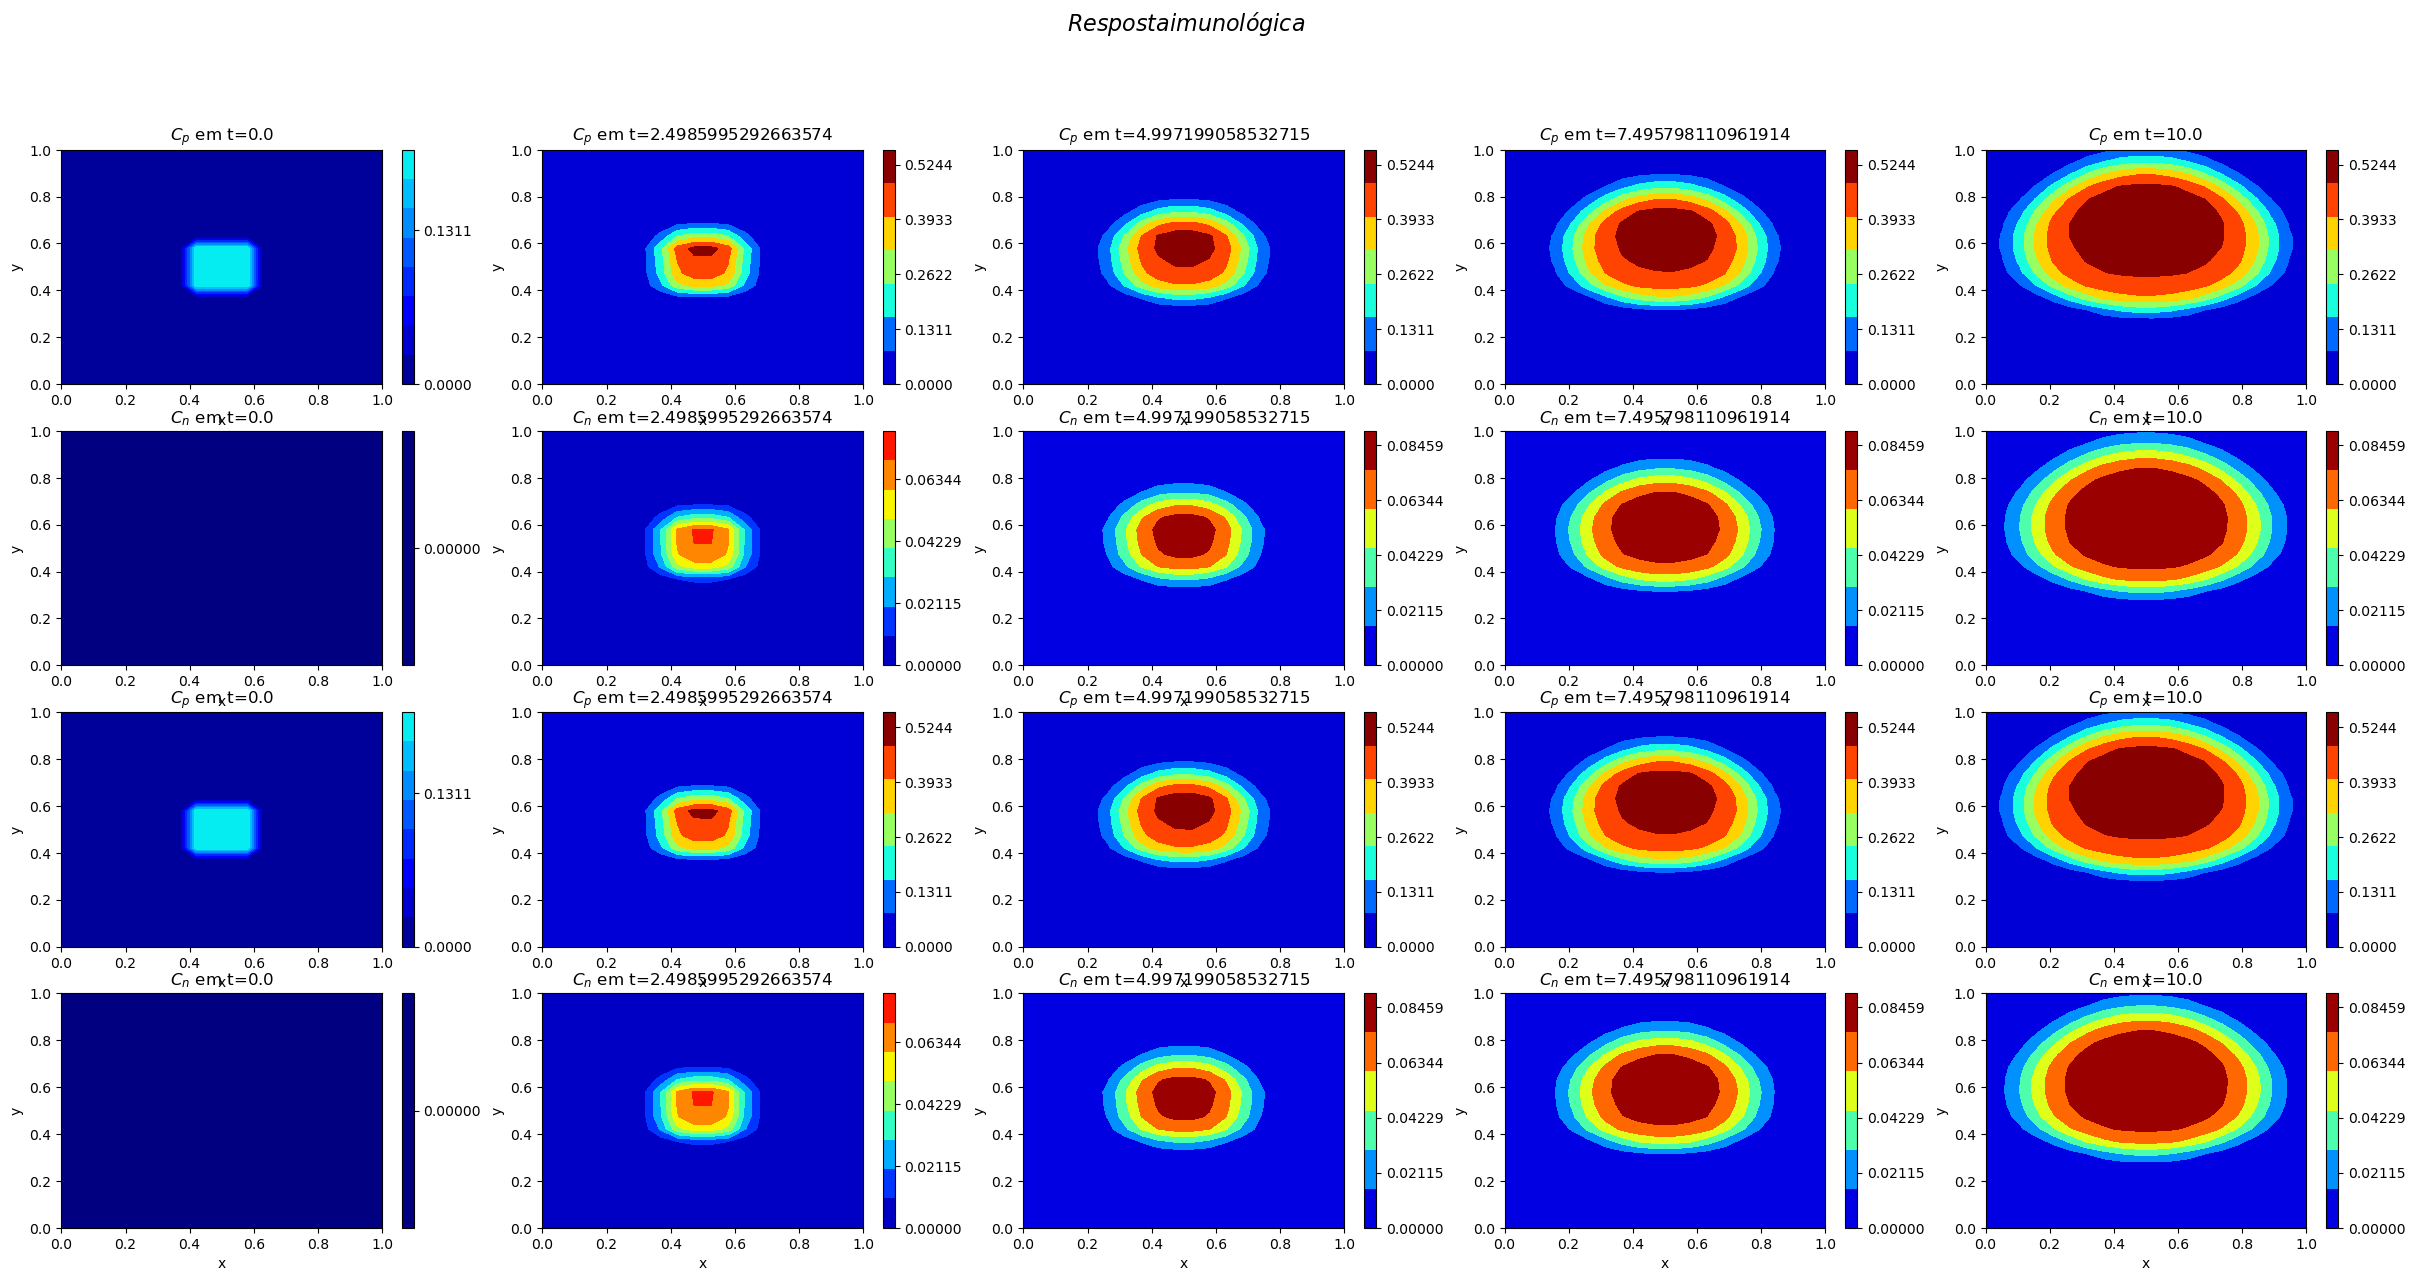

In [10]:
import matplotlib.pyplot as plt

t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x_np = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=True, dtype=np.float32)
y_np = np.linspace(y_dom[0], y_dom[-1], num=size_y, endpoint=True, dtype=np.float32)


X, Y = np.meshgrid(
    x_np,
    y_np,
)

time_plot = np.linspace(0, size_t - 1, num=5, endpoint=True, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 14])

fig.suptitle("$Resposta imunológica$", fontsize=16)

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + 1)

    vmin = np.min(Cb_host)
    vmax = np.max(Cb_host)

    contour = ax.contourf(
        X,
        Y,
        Cb_host[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("$C_p$ em t={}".format(t_np[time_inst]))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) + 1)

    vmin = np.min(Cn_host)
    vmax = np.max(Cn_host)

    contour = ax.contourf(
        X,
        Y,
        Cn_host[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("$C_n$ em t={}".format(t_np[time_inst]))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) * 2 + 1)

    vmin = np.min(Cb)
    vmax = np.max(Cb)

    contour = ax.contourf(
        X,
        Y,
        Cb[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("$C_p$ em t={}".format(t_np[time_inst]))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) * 3 + 1)

    vmin = np.min(Cn)
    vmax = np.max(Cn)

    contour = ax.contourf(
        X,
        Y,
        Cn[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("$C_n$ em t={}".format(t_np[time_inst]))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()